# Meta-Algorithm for fair classification.
The fairness metrics to be optimized have to specified as "input". Currently we can handle the following fairness metrics:
Statistical Rate, False Positive Rate, True Positive Rate, False Negative Rate, True Negative Rate,
Accuracy Rate, False Discovery Rate, False Omission Rate, Positive Predictive Rate, Negative Predictive Rate.

-----------------------------

The example below considers the cases of False Discovery Parity and Statistical Rate (disparate impact).


In [55]:
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
from tqdm import tqdm
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.inprocessing import MetaFairClassifier

np.random.seed(12345)

## Original Training dataset

In [56]:
dataset_orig = load_preproc_data_adult()

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

In [49]:
dataset_orig = GermanDataset()
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

In [57]:
min_max_scaler = MaxAbsScaler()
dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)

In [35]:
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex', 'race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


In [36]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = {:.3f}".format(metric_orig_train.mean_difference()))
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = {:.3f}".format(metric_orig_test.mean_difference()))

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.193
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.197


## Algorithm without debiasing

Get classifier without fairness constraints

In [58]:
biased_model = MetaFairClassifier(tau=0, sensitive_attr="sex", type="fdr").fit(dataset_orig_train)

Apply the unconstrained model to test data

In [59]:
dataset_bias_test = biased_model.predict(dataset_orig_test)

In [39]:
classified_metric_bias_test = ClassificationMetric(dataset_orig_test, dataset_bias_test,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)
print("Test set: Classification accuracy = {:.3f}".format(classified_metric_bias_test.accuracy()))
TPR = classified_metric_bias_test.true_positive_rate()
TNR = classified_metric_bias_test.true_negative_rate()
bal_acc_bias_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = {:.3f}".format(bal_acc_bias_test))
print("Test set: Disparate impact = {:.3f}".format(classified_metric_bias_test.disparate_impact()))
fdr = classified_metric_bias_test.false_discovery_rate_ratio()
fdr = min(fdr, 1/fdr)
print("Test set: False discovery rate ratio = {:.3f}".format(fdr))

Test set: Classification accuracy = 0.789
Test set: Balanced classification accuracy = 0.623
Test set: Disparate impact = 0.466
Test set: False discovery rate ratio = 0.508


## Debiasing with FDR objective

Learn a debiased classifier

In [40]:
debiased_model = MetaFairClassifier(tau=0.7, sensitive_attr="sex", type="fdr").fit(dataset_orig_train)

Apply the debiased model to test data

In [41]:
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

### Model - with debiasing - dataset metrics

In [42]:
metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = {:.3f}".format(metric_dataset_debiasing_test.mean_difference()))

Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.110


### Model - with debiasing - classification metrics

In [43]:
classified_metric_debiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = {:.3f}".format(classified_metric_debiasing_test.accuracy()))
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = {:.3f}".format(bal_acc_debiasing_test))
print("Test set: Disparate impact = {:.3f}".format(classified_metric_debiasing_test.disparate_impact()))
fdr = classified_metric_debiasing_test.false_discovery_rate_ratio()
fdr = min(fdr, 1/fdr)
print("Test set: False discovery rate ratio = {:.3f}".format(fdr))

Test set: Classification accuracy = 0.657
Test set: Balanced classification accuracy = 0.713
Test set: Disparate impact = 0.794
Test set: False discovery rate ratio = 0.660


We see that the FDR ratio has increased meaning it is now closer to parity.

## Running the algorithm for different tau values

In [46]:
accuracies, statistical_rates = [], []
s_attr = "sex"

all_tau = np.linspace(0, 0.9, 10)
for tau in tqdm(all_tau):
    debiased_model = MetaFairClassifier(tau=tau, sensitive_attr=s_attr, type='sr')
    debiased_model.fit(dataset_orig_train)

    dataset_debiasing_test = debiased_model.predict(dataset_orig_test)
    metric = ClassificationMetric(dataset_orig_test, dataset_debiasing_test,
                                  unprivileged_groups=[{s_attr: 0}],
                                  privileged_groups=[{s_attr: 1}])

    accuracies.append(metric.accuracy())
    sr = metric.disparate_impact()
    statistical_rates.append(min(sr, 1/sr))

100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Output fairness is represented by $\gamma_{sr}$, which is the disparate impact ratio of different sensitive attribute values.

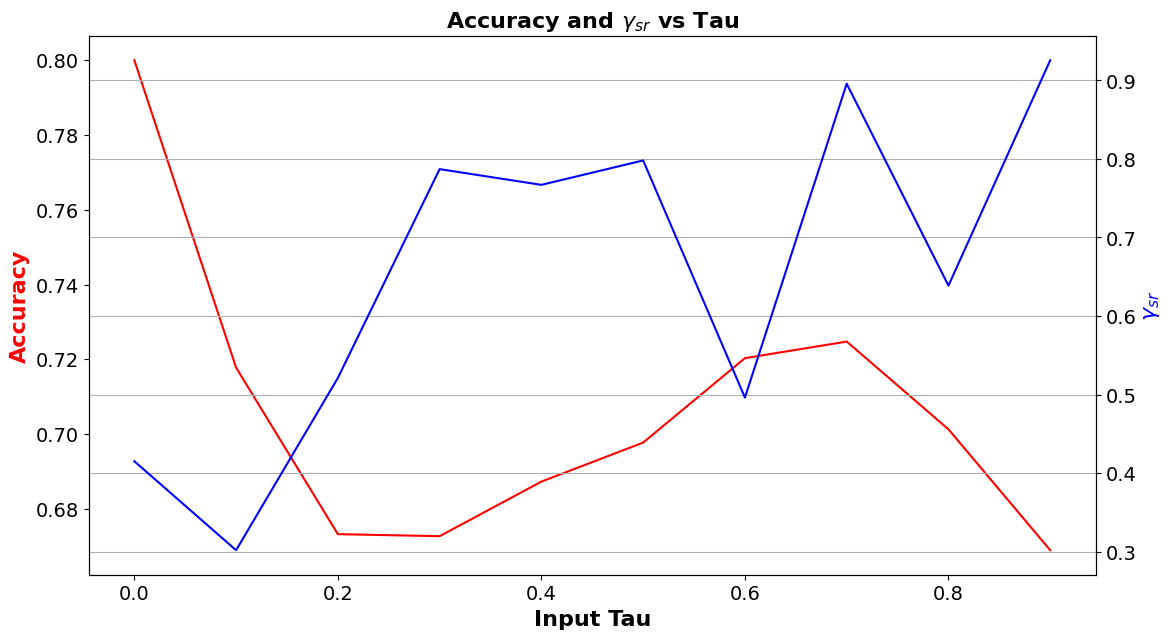

In [47]:
fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_tau, accuracies, color='r')
ax1.set_title('Accuracy and $\gamma_{sr}$ vs Tau', fontsize=16, fontweight='bold')
ax1.set_xlabel('Input Tau', fontsize=16, fontweight='bold')
ax1.set_ylabel('Accuracy', color='r', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_tau, statistical_rates, color='b')
ax2.set_ylabel('$\gamma_{sr}$', color='b', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [53]:
DEOO_fin = []
DPE_fin = []
mis_fin = []
sigma = 1
for step in tqdm(range(100)):
    mu_00 = 3 * np.random.rand(1)
    mu_01 = np.random.rand(1)
    mu_10 = np.random.rand(1)
    mu_11 = np.random.rand(1)
    for i in range(1000):
        if(dataset_orig.labels[i] == 2 and dataset_orig.features[:,7][i] == 0):
            #z = np.random.normal(mu_00, sigma, 57)
            #z = np.random.chisquare(2,57)
            z = np.random.standard_t(4, 57)
            for j in range(7):
                dataset_orig.features[i][j] = z[j]
            for j in range(8, 58):
                dataset_orig.features[i][j] = z[j - 1]
        elif(dataset_orig.labels[i] == 2 and dataset_orig.features[:,7][i] == 1):
            #z = np.random.normal(mu_01, sigma, 57)
            #z = np.random.standard_t(4, 57)
            z = np.random.chisquare(2,57)
            for j in range(7):
                dataset_orig.features[i][j] = z[j]
            for j in range(8, 58):
                dataset_orig.features[i][j] = z[j - 1]
        elif(dataset_orig.labels[i] == 1 and dataset_orig.features[:,7][i] == 0):
            #z = np.random.normal(mu_10, sigma, 57)\
            z = np.random.chisquare(4,57)
            for j in range(7):
                dataset_orig.features[i][j] = z[j]
            for j in range(8, 58):
                dataset_orig.features[i][j] = z[j - 1]
        else:
            #z = np.random.normal(mu_11, sigma, 57)
            #z = np.random.chisquare(1,57)
            z = np.random.laplace(mu_11, sigma, 57)
            for j in range(7):
                dataset_orig.features[i][j] = z[j]
            for j in range(8, 58):
                dataset_orig.features[i][j] = z[j - 1]
    randseed = np.random.randint(10000)
    dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.6], shuffle=True, seed = np.random.randint(0, 10000))
    dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True, seed = np.random.randint(0, 10000))
    # Placeholder for predicted and transformed datasets
    dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
    dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
    dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)

    dataset_new_valid_pred = dataset_orig_valid.copy(deepcopy=True)
    dataset_new_test_pred = dataset_orig_test.copy(deepcopy=True)

    y_test = dataset_orig_test.labels.ravel()

    debiased_model = MetaFairClassifier(tau=0.7, sensitive_attr="sex", type="fdr").fit(dataset_orig_train)
    dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

    eq = 0
    for i in range(len(y_test)):
        if(dataset_debiasing_test.labels.ravel()[i] == y_test[i]):
            eq += 1
    mis_fin.append(eq / len(y_test))
    n_10 = 0
    n_11 = 0
    c_10 = 0
    c_11 = 0
    for i in range(len(y_test)):
        if(y_test[i] == 1 and dataset_debiasing_test.protected_attributes[:,1][i] == 0):
            n_10 += 1
            if(dataset_debiasing_test.labels.ravel()[i] == 1):
                c_10 += 1
        elif(y_test[i] == 1 and dataset_debiasing_test.protected_attributes[:,1][i] == 1):
            n_11 += 1
            if(dataset_debiasing_test.labels.ravel()[i] == 1):
                c_11 += 1
    DEOO_fin.append(c_10 / n_10 - c_11 / n_11)
    n_00 = 0
    n_01 = 0
    c_00 = 0
    c_01 = 0
    for i in range(len(y_test)):
        if(y_test[i] == 2 and dataset_debiasing_test.protected_attributes[:,1][i] == 0):
            n_00 += 1
            if(dataset_debiasing_test.labels.ravel()[i] == 1):
                c_00 += 1
        elif(y_test[i] == 2 and dataset_debiasing_test.protected_attributes[:,1][i] == 1):
            n_01 += 1
            if(dataset_debiasing_test.labels.ravel()[i] == 1):
                c_01 += 1
    DPE_fin.append(c_00 / n_00 - c_01 / n_01)
DEOO_fin = np.array(DEOO_fin)
DPE_fin = np.array(DPE_fin)
mis_fin = np.array(mis_fin)

100%|██████████| 100/100 [04:16<00:00,  2.56s/it]


In [61]:
DEOO_fin = []
DPE_fin = []
mis_fin = []
sigma = 1
for step in tqdm(range(100)):
    randseed = np.random.randint(10000)
    dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.6], shuffle=True, seed = np.random.randint(0, 10000))
    dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True, seed = np.random.randint(0, 10000))
    # Placeholder for predicted and transformed datasets
    dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
    dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
    dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)

    dataset_new_valid_pred = dataset_orig_valid.copy(deepcopy=True)
    dataset_new_test_pred = dataset_orig_test.copy(deepcopy=True)

    y_test = dataset_orig_test.labels.ravel()

    debiased_model = MetaFairClassifier(tau=0.7, sensitive_attr="sex", type="fdr").fit(dataset_orig_train)
    dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

    eq = 0
    for i in range(len(y_test)):
        if(dataset_debiasing_test.labels.ravel()[i] == y_test[i]):
            eq += 1
    mis_fin.append(eq / len(y_test))
    n_10 = 0
    n_11 = 0
    c_10 = 0
    c_11 = 0
    for i in range(len(y_test)):
        if(y_test[i] == 1 and dataset_debiasing_test.protected_attributes[:,1][i] == 0):
            n_10 += 1
            if(dataset_debiasing_test.labels.ravel()[i] == 1):
                c_10 += 1
        elif(y_test[i] == 1 and dataset_debiasing_test.protected_attributes[:,1][i] == 1):
            n_11 += 1
            if(dataset_debiasing_test.labels.ravel()[i] == 1):
                c_11 += 1
    DEOO_fin.append(c_10 / n_10 - c_11 / n_11)
    n_00 = 0
    n_01 = 0
    c_00 = 0
    c_01 = 0
    for i in range(len(y_test)):
        if(y_test[i] == 0 and dataset_debiasing_test.protected_attributes[:,1][i] == 0):
            n_00 += 1
            if(dataset_debiasing_test.labels.ravel()[i] == 1):
                c_00 += 1
        elif(y_test[i] == 0 and dataset_debiasing_test.protected_attributes[:,1][i] == 1):
            n_01 += 1
            if(dataset_debiasing_test.labels.ravel()[i] == 1):
                c_01 += 1
    DPE_fin.append(c_00 / n_00 - c_01 / n_01)
DEOO_fin = np.array(DEOO_fin)
DPE_fin = np.array(DPE_fin)
mis_fin = np.array(mis_fin)

100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


In [62]:
print(np.mean(abs(DEOO_fin)))
print(np.mean(abs(DPE_fin)))
print(np.mean(mis_fin))
print(np.percentile(mis_fin, 95))
print(np.percentile(abs(DEOO_fin), 95))
print(np.percentile(abs(DPE_fin), 95))

0.17228323181597385
0.19381204311392067
0.6879598730678679
0.7466424403726072
0.2529187688423358
0.27060087655248294


References:

     Celis, L. E., Huang, L., Keswani, V., & Vishnoi, N. K. (2018). 
     "Classification with Fairness Constraints: A Meta-Algorithm with Provable Guarantees.""
